In [1]:
import sys
import matplotlib.pyplot as plt
import mplfinance as mpl
import numpy as np
 
# Avoid AttributeError: module 'sqlalchemy' has no attribute 'orm'
import sqlalchemy.orm  # noqa: F401

sys.path.append("..")
from gmo_hft_bot.db.database import initialize_database
from gmo_hft_bot.db import crud
from backtest.visualize.ohlcv import ohlcv_plot
from backtest.utils.utils import get_ohlcv_df, get_predict_df, match_timestamp_for_ohlcv
from backtest.backtest_trade.richman_backtest import richman_backtest

In [3]:
symbol = "BTC_JPY"

_, SessionLocal = initialize_database(uri="sqlite:///../example.db")
with SessionLocal() as db:
    ohlcv_data = crud.get_ohlcv_with_symbol(db=db, symbol=symbol)
    predict_data = crud.get_predict_items(db=db, symbol=symbol)

time_span = 5
ohlcv_df = get_ohlcv_df(ohlcv_data, time_span=time_span)
buy_df, sell_df = get_predict_df(predict_data)
timestamped_buy_df = match_timestamp_for_ohlcv(ohlcv_df, buy_df, time_span)
timestamped_sell_df = match_timestamp_for_ohlcv(ohlcv_df, sell_df, time_span)

result_online = richman_backtest(ohlcv_df.copy(), buy_df=timestamped_buy_df.shift(-1), sell_df=timestamped_sell_df.shift(-1))

5


In [3]:
ohlcv_df.describe()

,open,high,low,close,volume
count,1.205300e+04,1.205300e+04,1.205300e+04,1.205300e+04,12053.000000
mean,5.687227e+06,5.687508e+06,5.686910e+06,5.687237e+06,0.194199
std,2.882580e+04,2.885364e+04,2.879345e+04,2.880928e+04,0.499202
min,5.591195e+06,5.592241e+06,5.590500e+06,5.591195e+06,0.000000
25%,5.671081e+06,5.671141e+06,5.671000e+06,5.671040e+06,0.000000
50%,5.687833e+06,5.688046e+06,5.687496e+06,5.687833e+06,0.020000
75%,5.704161e+06,5.704401e+06,5.704037e+06,5.704201e+06,0.160000
max,5.785648e+06,5.787034e+06,5.781465e+06,5.783853e+06,10.480000


/Users/akiranoda/projects/gmo-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


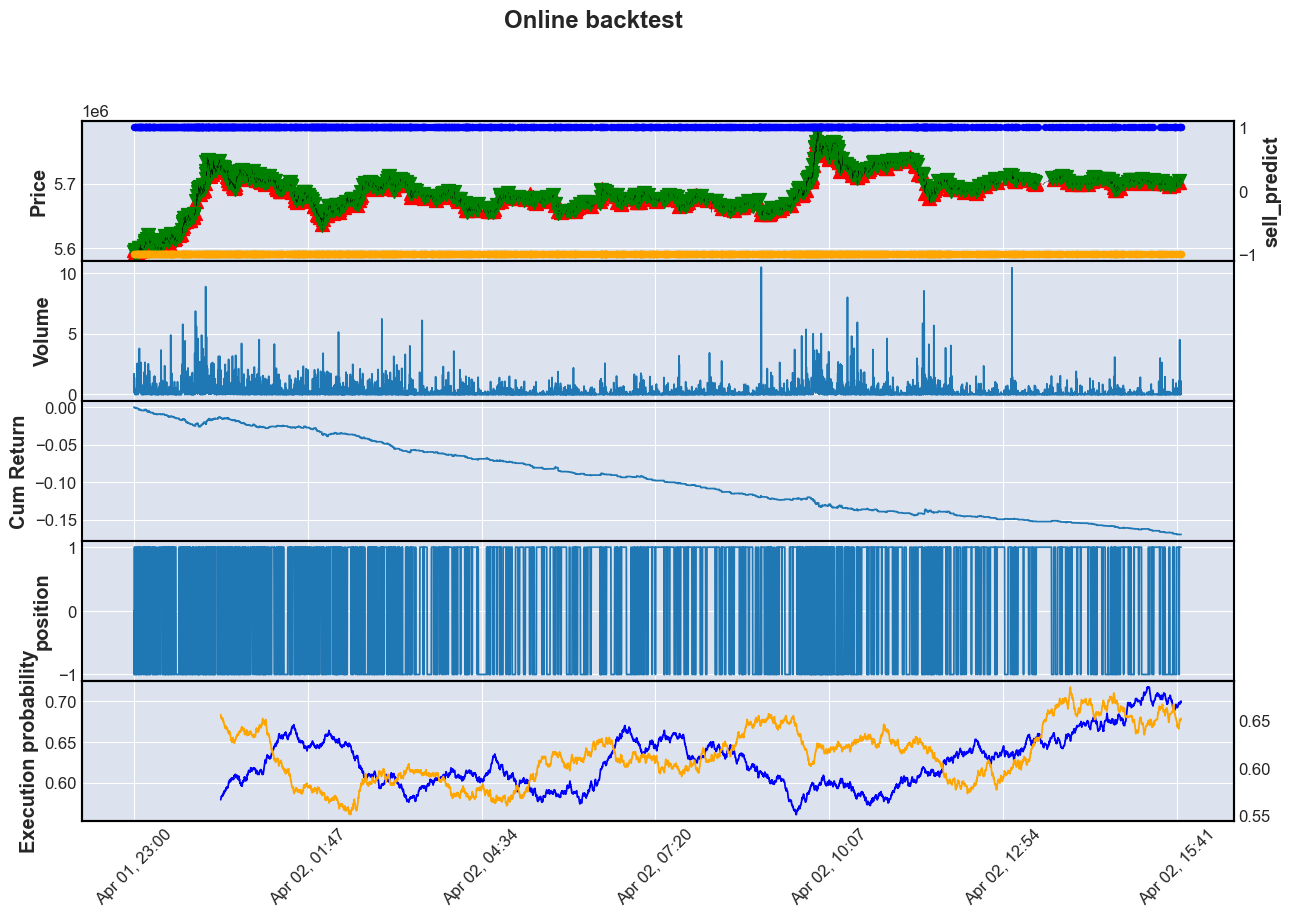

In [33]:
mpl_adds = [
    # Prediction plot
    mpl.make_addplot(np.where(timestamped_buy_df["is_entry"] == True, -1, np.nan), type="scatter", ylabel="buy_predict", color="orange", y_on_right=False),
    mpl.make_addplot(np.where(timestamped_sell_df["is_entry"] == True, 1, np.nan), type="scatter", ylabel="sell_predict", color="blue", y_on_right=False),

    # Entry plot
    mpl.make_addplot(result_online["buy_entry_price"] - 1000, type="scatter", markersize=100, marker="^", color="r"),
    mpl.make_addplot(result_online["sell_entry_price"] + 1000, type="scatter", markersize=100, marker="v", color="g"),

    # Volume plot
    mpl.make_addplot(ohlcv_df["volume"], type="line", panel=1, ylabel="Volume", y_on_right=False),

    # Cumulative plot
    mpl.make_addplot(result_online["cumulative_return"], type="line", panel=2, ylabel="Cum Return", y_on_right=False),

    # Position plot
    mpl.make_addplot(result_online["position"], type="line", panel=3, ylabel="position", y_on_right=False),

    # Execution plot
    mpl.make_addplot(result_online["buy_executed"].rolling(1000).mean(), type="line", panel=4, ylabel="Execution probability", color="blue", y_on_right=False),
    mpl.make_addplot(result_online["sell_executed"].rolling(1000).mean(), type="line", panel=4, color="orange", y_on_right=False),

]
fig, axes = mpl.plot(ohlcv_df, type="candle", addplot=mpl_adds, figsize=(16, 10), panel_ratios=(1,1), figratio=(1,1), figscale=1.5, title="Online backtest", returnfig=True)
plt.show()
plt.close()

In [35]:
# local data backtest
local_timestamped_buy_df = timestamped_buy_df.copy()
local_timestamped_sell_df = timestamped_sell_df.copy()
pips = 100
local_timestamped_buy_df['price'] = ohlcv_df.loc[:,'close'] - pips
local_timestamped_sell_df['price'] = ohlcv_df.loc[:,'close'] + pips
result_local = richman_backtest(ohlcv_df.copy(), buy_df=local_timestamped_buy_df.shift(-1), sell_df=local_timestamped_sell_df.shift(-1))

/Users/akiranoda/projects/gmo-websocket/.venv/lib/python3.9/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


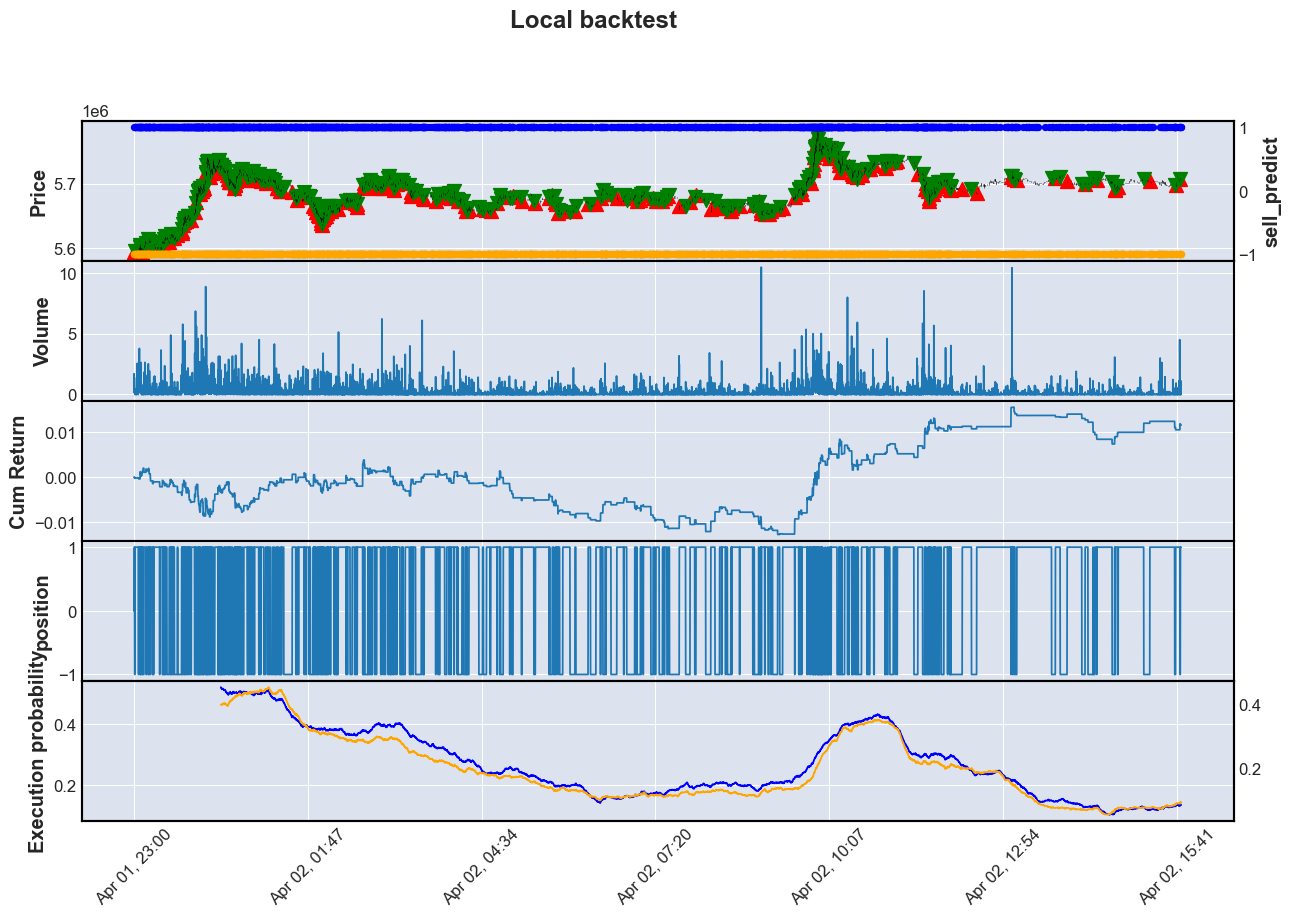

In [37]:
mpl_adds = [
    # Prediction plot
    mpl.make_addplot(np.where(timestamped_buy_df["is_entry"] == True, -1, np.nan), type="scatter", ylabel="buy_predict", color="orange", y_on_right=False),
    mpl.make_addplot(np.where(timestamped_sell_df["is_entry"] == True, 1, np.nan), type="scatter", ylabel="sell_predict", color="blue", y_on_right=False),

    # Entry plot
    mpl.make_addplot(result_local["buy_entry_price"] - 1000, type="scatter", markersize=100, marker="^", color="r"),
    mpl.make_addplot(result_local["sell_entry_price"] + 1000, type="scatter", markersize=100, marker="v", color="g"),

    # Volume plot
    mpl.make_addplot(ohlcv_df["volume"], type="line", panel=1, ylabel="Volume", y_on_right=False),

    # Cumulative plot
    mpl.make_addplot(result_local["cumulative_return"], type="line", panel=2, ylabel="Cum Return", y_on_right=False),

    # Position plot
    mpl.make_addplot(result_local["position"], type="line", panel=3, ylabel="position", y_on_right=False),

    # Execution plot
    mpl.make_addplot(result_local["buy_executed"].rolling(1000).mean(), type="line", panel=4, ylabel="Execution probability", color="blue", y_on_right=False),
    mpl.make_addplot(result_local["sell_executed"].rolling(1000).mean(), type="line", panel=4, color="orange", y_on_right=False),
]
mpl.plot(ohlcv_df, type="candle", addplot=mpl_adds, figsize=(16, 10), panel_ratios=(1,1), figratio=(1,1), figscale=1.5, title="Local backtest")
plt.close()

In [7]:

result_online.head(50)

,cumulative_return,position,buy_entry_price,sell_entry_price,buy_exit_price,sell_exit_price,buy_executed,sell_executed
timestamp,,,,,,,,
2022-04-01 23:00:50+00:00,0.000000,0.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:00:55+00:00,0.000000,0.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:01:00+00:00,0.000000,-1.0,NaN,5.593840e+06,NaN,NaN,False,True
2022-04-01 23:01:05+00:00,0.000000,-1.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:01:10+00:00,0.000000,-1.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:01:15+00:00,-0.000724,1.0,5.597889e+06,NaN,5.597889e+06,NaN,True,False
2022-04-01 23:01:20+00:00,-0.000724,1.0,NaN,NaN,NaN,NaN,True,False
2022-04-01 23:01:25+00:00,-0.001028,-1.0,NaN,5.596184e+06,NaN,5.596184e+06,True,True
2022-04-01 23:01:30+00:00,-0.001028,-1.0,NaN,NaN,NaN,NaN,True,False


In [8]:
ohlcv_df.describe()

,open,high,low,close,volume
count,1.205300e+04,1.205300e+04,1.205300e+04,1.205300e+04,12053.000000
mean,5.687227e+06,5.687508e+06,5.686910e+06,5.687237e+06,0.194199
std,2.882580e+04,2.885364e+04,2.879345e+04,2.880928e+04,0.499202
min,5.591195e+06,5.592241e+06,5.590500e+06,5.591195e+06,0.000000
25%,5.671081e+06,5.671141e+06,5.671000e+06,5.671040e+06,0.000000
50%,5.687833e+06,5.688046e+06,5.687496e+06,5.687833e+06,0.020000
75%,5.704161e+06,5.704401e+06,5.704037e+06,5.704201e+06,0.160000
max,5.785648e+06,5.787034e+06,5.781465e+06,5.783853e+06,10.480000


In [9]:
pips = 500
ohlcv_df["local_buy_price"] = ohlcv_df["close"] - pips
merged_buy_df = timestamped_buy_df.merge(ohlcv_df["local_buy_price"], right_index=True, left_index=True)
merged_buy_df["subt_online_local"] = merged_buy_df["price"] - merged_buy_df["local_buy_price"]
merged_buy_df[['price', "local_buy_price", "subt_online_local"]].tail(30)

,price,local_buy_price,subt_online_local
timestamp,,,
2022-04-02 15:42:55+00:00,5.703897e+06,5702299.0,1598.014286
2022-04-02 15:43:00+00:00,5.703978e+06,5702299.0,1679.014286
2022-04-02 15:43:05+00:00,5.703921e+06,5702299.0,1622.014286
2022-04-02 15:43:10+00:00,5.703908e+06,5702299.0,1609.114286
2022-04-02 15:43:15+00:00,5.703867e+06,5702299.0,1568.114286
2022-04-02 15:43:20+00:00,5.704127e+06,5702299.0,1828.114286
2022-04-02 15:43:25+00:00,5.704397e+06,5703888.0,509.114286
2022-04-02 15:43:30+00:00,5.704289e+06,5702310.0,1978.900000
2022-04-02 15:43:35+00:00,5.703634e+06,5702836.0,798.271429


In [10]:
ohlcv_df.head(20)

,open,high,low,close,volume,local_buy_price
timestamp,,,,,,
2022-04-01 23:00:50+00:00,5592660.0,5594505.0,5592650.0,5594505.0,1.31,5594005.0
2022-04-01 23:00:55+00:00,5595196.0,5595869.0,5594256.0,5595793.0,1.70,5595293.0
2022-04-01 23:01:00+00:00,5594466.0,5595400.0,5592700.0,5592700.0,0.51,5592200.0
2022-04-01 23:01:05+00:00,5593655.0,5594992.0,5593167.0,5594992.0,0.20,5594492.0
2022-04-01 23:01:10+00:00,5594992.0,5596128.0,5594825.0,5596039.0,1.40,5595539.0
2022-04-01 23:01:15+00:00,5596128.0,5599116.0,5595676.0,5599116.0,0.48,5598616.0
2022-04-01 23:01:20+00:00,5597730.0,5597730.0,5596141.0,5596141.0,0.14,5595641.0
2022-04-01 23:01:25+00:00,5596185.0,5597293.0,5595367.0,5596204.0,0.18,5595704.0
2022-04-01 23:01:30+00:00,5594842.0,5596652.0,5594091.0,5594425.0,0.44,5593925.0


In [11]:
ohlcv_df["std_vol"] = ohlcv_df["volume"].rolling(10).std()
print(ohlcv_df["std_vol"][0])
ohlcv_df[50:].head(50)

nan


,open,high,low,close,volume,local_buy_price,std_vol
timestamp,,,,,,,
2022-04-01 23:05:00+00:00,5593500.0,5595196.0,5592693.0,5595005.0,1.00,5594505.0,0.492803
2022-04-01 23:05:05+00:00,5595797.0,5598693.0,5595595.0,5597480.0,2.42,5596980.0,0.767455
2022-04-01 23:05:10+00:00,5597480.0,5597953.0,5595927.0,5595963.0,0.44,5595463.0,0.771553
2022-04-01 23:05:15+00:00,5595963.0,5595963.0,5593348.0,5594311.0,1.46,5593811.0,0.791300
2022-04-01 23:05:20+00:00,5595221.0,5595963.0,5593800.0,5595963.0,0.42,5595463.0,0.759778
2022-04-01 23:05:25+00:00,5596836.0,5596943.0,5595194.0,5595850.0,0.58,5595350.0,0.729764
2022-04-01 23:05:30+00:00,5596354.0,5596822.0,5596203.0,5596822.0,0.22,5596322.0,0.756083
2022-04-01 23:05:35+00:00,5596822.0,5596822.0,5595809.0,5596527.0,0.24,5596027.0,0.757777
2022-04-01 23:05:40+00:00,5596925.0,5600000.0,5596915.0,5600000.0,1.90,5599500.0,0.765814


In [12]:
std20 = ohlcv_df["close"].rolling(20).std()
ohlcv_df["bb_upper"] = (ohlcv_df["close"] + std20 * 2.0).rolling(5).mean()
ohlcv_df["bb_lower"] = (ohlcv_df["close"] - std20 * 2.0).rolling(5).mean()

ohlcv_df["std_vol"] = ohlcv_df["volume"].rolling(15).std()
ohlcv_df[90:].head(50)

,open,high,low,close,volume,local_buy_price,std_vol,bb_upper,bb_lower
timestamp,,,,,,,,,
2022-04-01 23:08:20+00:00,5599999.0,5600074.0,5598401.0,5600074.0,0.30,5599574.0,0.672006,5.604797e+06,5.590144e+06
2022-04-01 23:08:25+00:00,5600074.0,5600074.0,5600074.0,5600074.0,0.00,5599574.0,0.680078,5.605720e+06,5.591171e+06
2022-04-01 23:08:30+00:00,5600074.0,5600074.0,5600074.0,5600074.0,0.20,5599574.0,0.679620,5.606491e+06,5.592350e+06
2022-04-01 23:08:35+00:00,5598804.0,5598804.0,5597100.0,5597101.0,0.42,5596601.0,0.677613,5.606156e+06,5.592773e+06
2022-04-01 23:08:40+00:00,5597109.0,5597109.0,5597101.0,5597101.0,0.26,5596601.0,0.678253,5.605126e+06,5.592644e+06
2022-04-01 23:08:45+00:00,5595090.0,5595090.0,5595090.0,5595090.0,0.04,5594590.0,0.289586,5.603721e+06,5.592055e+06
2022-04-01 23:08:50+00:00,5595090.0,5595090.0,5595090.0,5595090.0,0.00,5594590.0,0.167710,5.602307e+06,5.591475e+06
2022-04-01 23:08:55+00:00,5595479.0,5597101.0,5595479.0,5597101.0,0.20,5596601.0,0.166548,5.601403e+06,5.591190e+06
2022-04-01 23:09:00+00:00,5595134.0,5595307.0,5595000.0,5595307.0,0.30,5594807.0,0.168050,5.600867e+06,5.591008e+06


In [13]:
timestamped_buy_df[90:].head(50)

,side,price,size,predict_value,symbol,is_entry,acutual_timestamp
timestamp,,,,,,,
2022-04-01 23:08:20+00:00,BUY,5.598648e+06,0.01,1.000279,BTC_JPY,True,2022-04-01 23:08:20.461000+00:00
2022-04-01 23:08:25+00:00,BUY,5.599388e+06,0.01,1.000078,BTC_JPY,True,2022-04-01 23:08:25.698000+00:00
2022-04-01 23:08:30+00:00,BUY,5.598601e+06,0.01,1.000000,BTC_JPY,False,2022-04-01 23:08:30.049000+00:00
2022-04-01 23:08:35+00:00,BUY,5.599110e+06,0.01,0.999977,BTC_JPY,False,2022-04-01 23:08:35.787000+00:00
2022-04-01 23:08:40+00:00,BUY,5.597107e+06,0.01,0.999848,BTC_JPY,False,2022-04-01 23:08:40.437000+00:00
2022-04-01 23:08:45+00:00,BUY,5.596825e+06,0.01,0.999999,BTC_JPY,False,2022-04-01 23:08:45.677000+00:00
2022-04-01 23:08:50+00:00,BUY,5.594744e+06,0.01,1.000000,BTC_JPY,False,2022-04-01 23:08:50.071000+00:00
2022-04-01 23:08:55+00:00,BUY,5.595090e+06,0.01,1.000000,BTC_JPY,False,2022-04-01 23:08:55.551000+00:00
2022-04-01 23:09:00+00:00,BUY,5.596816e+06,0.01,1.000145,BTC_JPY,True,2022-04-01 23:09:00.753000+00:00


In [14]:
timestamped_sell_df[80:150].head(50)

,side,price,size,predict_value,symbol,is_entry,acutual_timestamp
timestamp,,,,,,,
2022-04-01 23:07:30+00:00,SELL,5.599473e+06,0.01,1.000147,BTC_JPY,False,2022-04-01 23:07:30.670000+00:00
2022-04-01 23:07:35+00:00,SELL,5.597400e+06,0.01,0.999964,BTC_JPY,True,2022-04-01 23:07:35.255000+00:00
2022-04-01 23:07:40+00:00,SELL,5.595546e+06,0.01,1.000000,BTC_JPY,False,2022-04-01 23:07:40.307000+00:00
2022-04-01 23:07:45+00:00,SELL,5.594426e+06,0.01,0.999832,BTC_JPY,True,2022-04-01 23:07:45.557000+00:00
2022-04-01 23:07:50+00:00,SELL,5.592202e+06,0.01,1.000057,BTC_JPY,False,2022-04-01 23:07:51.731000+00:00
2022-04-01 23:07:55+00:00,SELL,5.593632e+06,0.01,1.000028,BTC_JPY,False,2022-04-01 23:07:55.748000+00:00
2022-04-01 23:08:00+00:00,SELL,5.594984e+06,0.01,1.000109,BTC_JPY,False,2022-04-01 23:08:00.327000+00:00
2022-04-01 23:08:05+00:00,SELL,5.594772e+06,0.01,1.000000,BTC_JPY,False,2022-04-01 23:08:05.259000+00:00
2022-04-01 23:08:10+00:00,SELL,5.594680e+06,0.01,1.000000,BTC_JPY,False,2022-04-01 23:08:10.069000+00:00


In [15]:
result_online[80:].head(50)

,cumulative_return,position,buy_entry_price,sell_entry_price,buy_exit_price,sell_exit_price,buy_executed,sell_executed
timestamp,,,,,,,,
2022-04-01 23:07:30+00:00,-0.004220,-1.0,NaN,5.597400e+06,NaN,5.597400e+06,True,True
2022-04-01 23:07:35+00:00,-0.004220,-1.0,NaN,NaN,NaN,NaN,True,True
2022-04-01 23:07:40+00:00,-0.004220,-1.0,NaN,NaN,NaN,NaN,True,False
2022-04-01 23:07:45+00:00,-0.004220,-1.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:07:50+00:00,-0.004220,-1.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:07:55+00:00,-0.004220,-1.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:08:00+00:00,-0.004220,-1.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:08:05+00:00,-0.004220,-1.0,NaN,NaN,NaN,NaN,False,True
2022-04-01 23:08:10+00:00,-0.004220,-1.0,NaN,NaN,NaN,NaN,False,True
